### Maximize Utility for Quantum Entanglement Switch 

We reproduce parts of the analytical results of [Vardoyan et al., 2023](https://ieeexplore.ieee.org/abstract/document/10313675) and compare them to our simplest simulation setup `surrogate_vardoyan_netsquid_comparison.py`. 

<img src="../Images/users-server-topology.png" width="500" height="300">

A four-node, three-link topology, where user-server pairs wish to communicate. |
Settings:
- Attempt rate T = 10−3 s. 
- Links 1 and 2: 2 km long
- Link 3: varied.
- Buffer size B is unlimited for all users


In [2]:
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import pickle

font = 20
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'arial',
    'font.size': font,
    'axes.labelsize': font,  
    'xtick.labelsize': font,  
    'ytick.labelsize': font, 
    'legend.fontsize': font,
    'legend.title_fontsize': font
})

beta = 0.2 # attenuation in fiber
c_loss = 1 # other system losses

attempt_durations_l = [10 ** -3, 10 ** -3] # [s]

def Fidel(w):
    return (3*w+1)/4 

def D_H(w1,w2):
    F = Fidel(w1*w2)
    return 1 + F*np.log2(F) + (1-F) * np.log2((1-F)/3) if F > 0.81 else 1e-10 # yield of the so-called “hashing” protocol

def U_D(R, w1, w2): 
    val = np.log(R*D_H(w1,w2))
    return val

def Objective(x):
    R, w1, w2 = x
    return - 2*U_D(R, w1, w2) + (2*R - d_l[0]*(1-w1))**2 + (R - d_l[1]*(1-w2))**2 

res = {'Distance [km]':[], 'Server link':[], 'User link':[], 'Utility':[], 'Rate':[], 'Fidelity':[]}
for i in [1.5**k for k in np.linspace(1,11.5,15)]:
    distances_l = [i, 2] # [km]

    eta_l = 10 ** (-0.1 * beta * np.array(distances_l)/2) # transmissivity between one link end and midpoint station
    d_l = 3 * c_loss * eta_l / (2*np.array(attempt_durations_l))

    sol = minimize(Objective, x0=(75, 0.95, 0.95), bounds=( (1,80), (0.85,1.), (0.85,1.)), method='L-BFGS-B')
    rate, ws, wu = sol.x
    U = U_D(rate, ws, wu)

    res['Server link'].append(Fidel(ws))
    res['User link'].append(Fidel(wu))
    res['Utility'].append(2*U) # aggregated utility
    res['Fidelity'].append(Fidel(ws*wu))
    res['Rate'].append(rate) 
    res['Distance [km]'].append(i) 
df_res = pd.DataFrame.from_records(res)


In [3]:
df_plot = df_res.melt(id_vars=['Distance [km]', 'Fidelity', 'Rate', 'Utility'], var_name='Type', value_name='Link Fidelity')

Get simulation results: Either run `surrogate_vardoyan_netsquid_comparison.py` with seeds SEED=1,2, ..., 10 (execution time ~ 4h) or retrieve data from ... [LINK!!]

In [4]:
dfs = []
for name in glob.glob(f'../../../surdata/qswitch/Sur_df*.csv'):
    with open(name,'rb') as file: dfs.append(pd.read_csv(name))

df = pd.concat(dfs, ignore_index=True)

Visualization

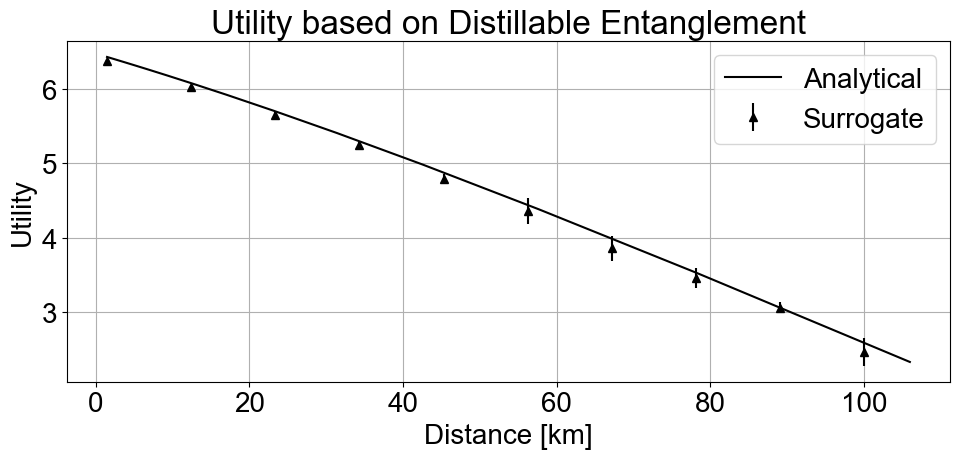

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
grouped= df.groupby('server_distance')
plt.plot(df_res['Distance [km]'], df_res['Utility'], color='black', label='Analytical')
plt.errorbar(grouped['Utility'].mean().index, grouped['Utility'].mean().values , grouped['Utility'].std().values, fmt='^', color='black', label='Surrogate')
plt.grid()
plt.title('Utility based on Distillable Entanglement')
plt.ylabel('Utility')
plt.xlabel('Distance [km]')
plt.legend()
plt.tight_layout()
plt.savefig('../Images/QES-example1-utility.pdf')

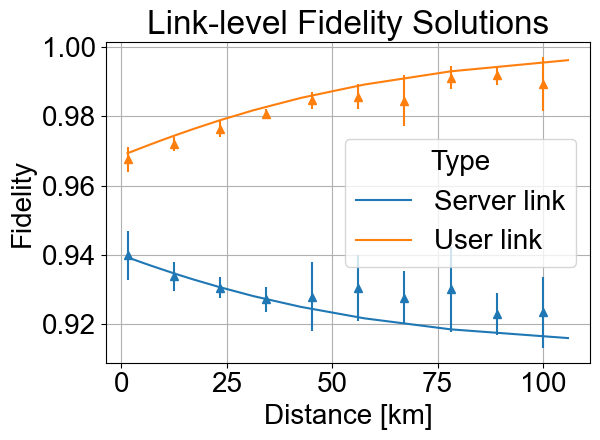

In [6]:
plt.errorbar(grouped['bright_state_server'].mean().index, 1-grouped['bright_state_server'].mean().values , grouped['bright_state_server'].std().values, fmt='^', color='tab:blue')
plt.errorbar(grouped['bright_state_user'].mean().index, 1-grouped['bright_state_user'].mean().values , grouped['bright_state_user'].std().values, fmt='^', color='tab:orange')
sns.lineplot(data=df_plot, x='Distance [km]', y='Link Fidelity', hue='Type', markers=True)
plt.ylabel('Fidelity')
plt.xlabel('Distance [km]')
plt.ylabel('Fidelity')
plt.grid()
plt.title('Link-level Fidelity Solutions')
plt.tight_layout()
plt.savefig('../Images/QES-example1-LinkFidelity.pdf')

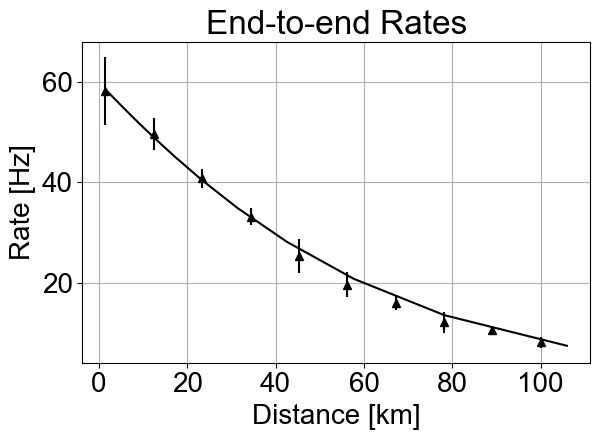

In [7]:
fig, ax1 = plt.subplots()
plt.errorbar(grouped['Rate'].mean().index, grouped['Rate'].mean().values , grouped['Rate'].std().values, fmt='^', color='black')
sns.lineplot(data=df_res, x='Distance [km]', y='Rate', markers=True, color='black', ax=ax1)
plt.xlabel('Distance [km]')
plt.ylabel('Rate [Hz]')
plt.grid()
plt.title('End-to-end Rates')
plt.tight_layout()
plt.savefig('../Images/QES-example1-Rate.pdf')

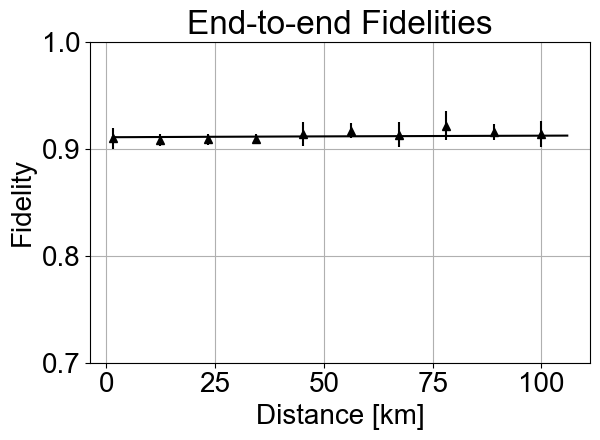

In [8]:
sns.lineplot(data=df_res, x='Distance [km]', y='Fidelity', markers=True, color='black')
plt.errorbar(grouped['Fidelity'].mean().index, grouped['Fidelity'].mean().values , grouped['Fidelity'].std().values, fmt='^', color='black')
plt.ylim([0.7,1])
plt.grid()
plt.title('End-to-end Fidelities')
plt.tight_layout()
plt.savefig('../Images/QES-example1-Fidelity.pdf')

Werner states $\rho_w$ are equivalent to how we model depolarization in simulation $\rho_{depol}$:
$$\rho_{B00} = |\Psi^+><\Psi^+|$$
$$ \rho_w  = w \rho_{B00} + (1-w) \frac{I_4}{4}$$

$$\rho_{depol} = (1-\frac{3}{4}p)I\rho_{B00}I + \frac{p}{4}(X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$ 
$$\rho_{depol} = (1-\frac{3}{4}p + \frac{1}{4}p - \frac{1}{4}p)I\rho_{B00}I + \frac{p}{4}(X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$
$$\rho_{depol} = (1-p)I\rho_{B00}I + \frac{p}{4}(I\rho_{B00}I + X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$
$$\rho_{depol} = (1-p)\rho_{B00} + \frac{p}{4}I$$
$$\rightarrow w = 1-p$$

Thus, we need to set the probability of an error happening to 
$$F = \frac{3w+1}{4} = 1-\alpha$$
$$\rightarrow w = 1 - \frac{4}{3}\alpha $$
$$\rightarrow p = 4/3\alpha $$

in our depolarization-error model in fiber (take a look at`netsquid_error_model.py`). 